In [1]:
from algorithms.schedules_optimization import schedule_optimizer, schedule_optimizer_ev,build_delta,build_omega
from algorithms.hamiltonian import get_mapping
from algorithms.ev_costs import ev_cost, average_ev_cost,qubo_ev, find_gs,approx_ratio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from pulser import Pulse,InterpolatedWaveform,DigitalAnalogDevice,Sequence
from pulser_simulation import QutipEmulator
import pickle
from itertools import product

### Analysys of 3x3 instance

In [2]:
N=3
T=3

# load registers and problem parameters
with open(f"results/parameters_N_{str(N)}_T_{str(T)}.pkl","rb") as fp:
    params = pickle.load(fp)
with open(f"results/reg_N_{str(N)}_T_{str(T)}.pkl","rb") as fp:
    reg = pickle.load(fp)

#QUBO matrix
Q = np.load(f"results/Q_N_{str(N)}_T_{str(T)}.npy",allow_pickle = True)

gs, gs_str, energies = find_gs(params,Q)
energies = sorted(energies[0:10])

print('exact gs: ', gs, gs_str)

exact gs:  -230.62463136924188 110011101


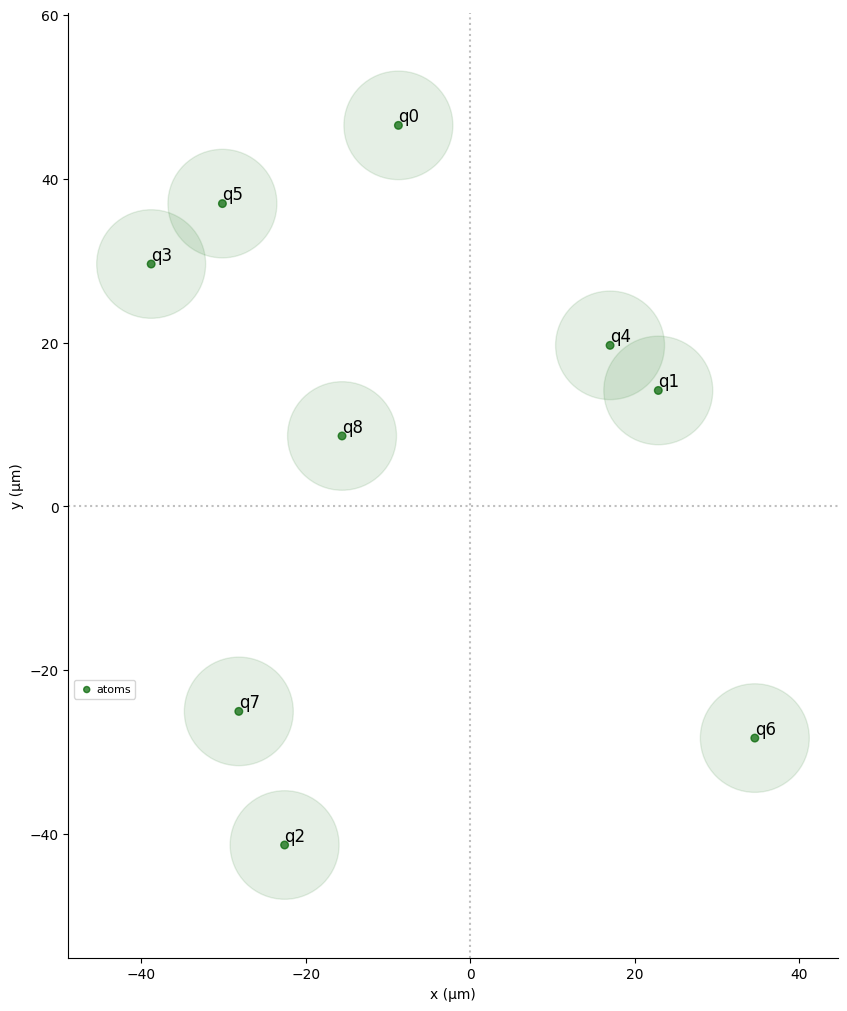

In [ ]:
#Plot of the atoms configuration
reg.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
)

In [ ]:
#read output of the costs
output = pd.read_csv(f"results/output_{str(N)}_{str(T)}.csv")
#assign costs
cost = output["cost"][1:9]
cost_baseline = output["cost_baseline"][1:9]
#ground state energy
gs = output["exact_gs"][1]
#time in nanoseconds
times = np.array(output["time"][1:9])

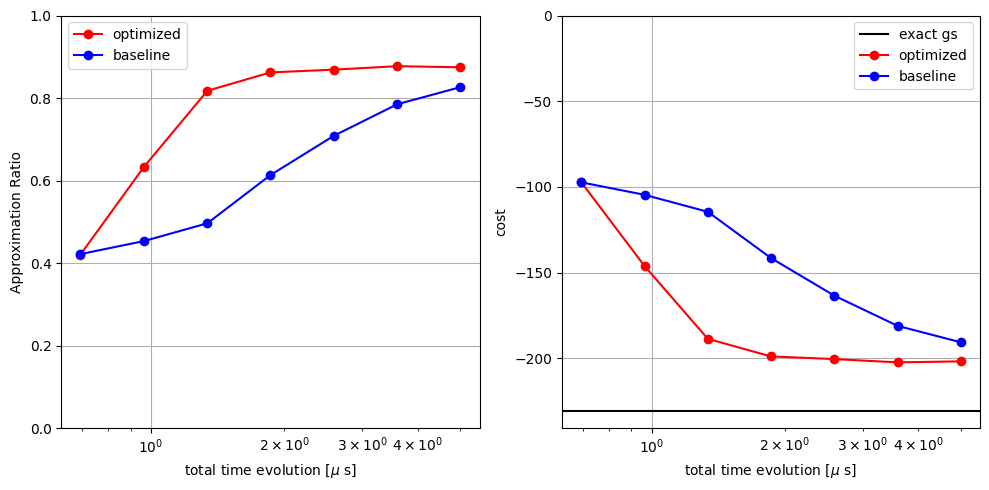

In [ ]:
#read schedule dataframe 
omega_data = np.load(f"results/omega_schedules_{str(N)}_{str(T)}.npy")
delta_data = np.load(f"results/delta_schedules_{str(N)}_{str(T)}.npy")
#assign schedules and annealing times

ar = [1-abs((gs - x)/gs) for x in cost]
ar_baseline = [1-abs((gs - x)/gs) for x in cost_baseline]

fig,axs = plt.subplots(ncols = 2, nrows = 1,figsize = (10,5))


axs[0].plot(times/1000,ar,'ro-',label='optimized')
axs[0].plot(times/1000,ar_baseline,'bo-',label='baseline')
axs[0].set_xlabel(r'total time evolution [$\mu$ s]')
axs[0].set_ylabel(r'Approximation Ratio')
axs[0].set_ylim(0,1)

axs[1].axhline(y = gs, color = 'k', linestyle = '-',label = 'exact gs')
axs[1].plot(times/1000,cost,'ro-',label='optimized')
axs[1].plot(times/1000,cost_baseline,'bo-',label='baseline')
axs[1].set_xlabel(r'total time evolution [$\mu$ s]')
axs[1].set_ylabel(r'cost')
axs[1].set_ylim(gs-10,0)

for ax in axs:
    ax.set_xscale('log')
    ax.legend()
    ax.grid()
    #ax.set_ylim(0,1)
fig.tight_layout()
fig.savefig(f'ar_size_N{str(N)}_T{str(T)}.png')

# Plot of the schedules for comparison

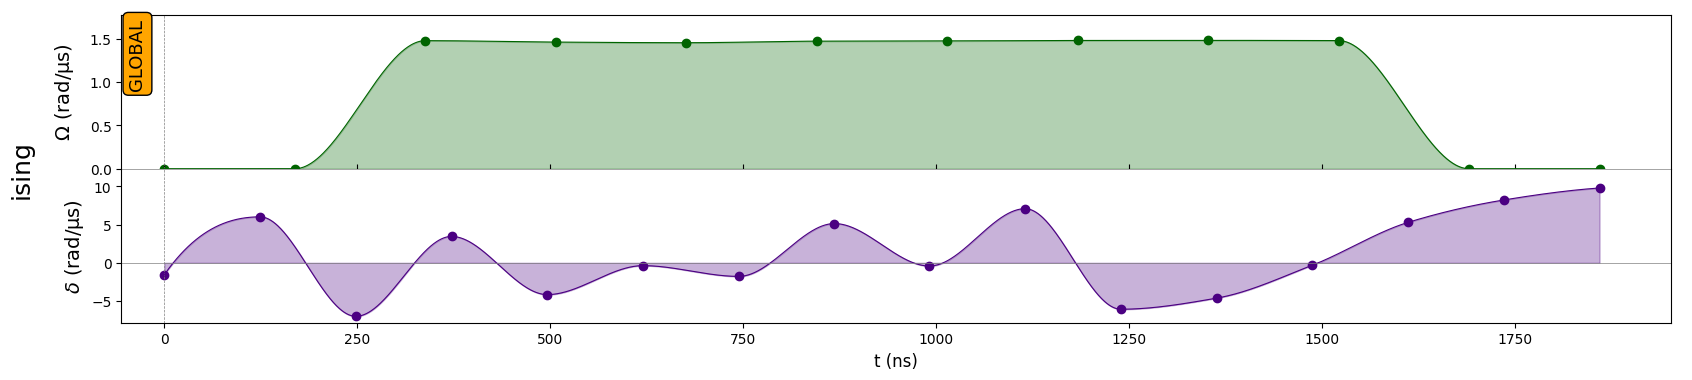

In [12]:
#Optimized schedule
#select a time index
i = 3
t = times[i]
omega = omega_data[i]
delta = delta_data[i]

omega_pulse = build_omega(omega)
delta_pulse = build_delta(delta)

# Construct the adiabatic pulse
adiabatic_pulse = Pulse(
    InterpolatedWaveform(t, omega_pulse),
    InterpolatedWaveform(t, delta_pulse),
    0,
)

# Create a sequence with the specified pulse
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse, "ising")

seq.draw()

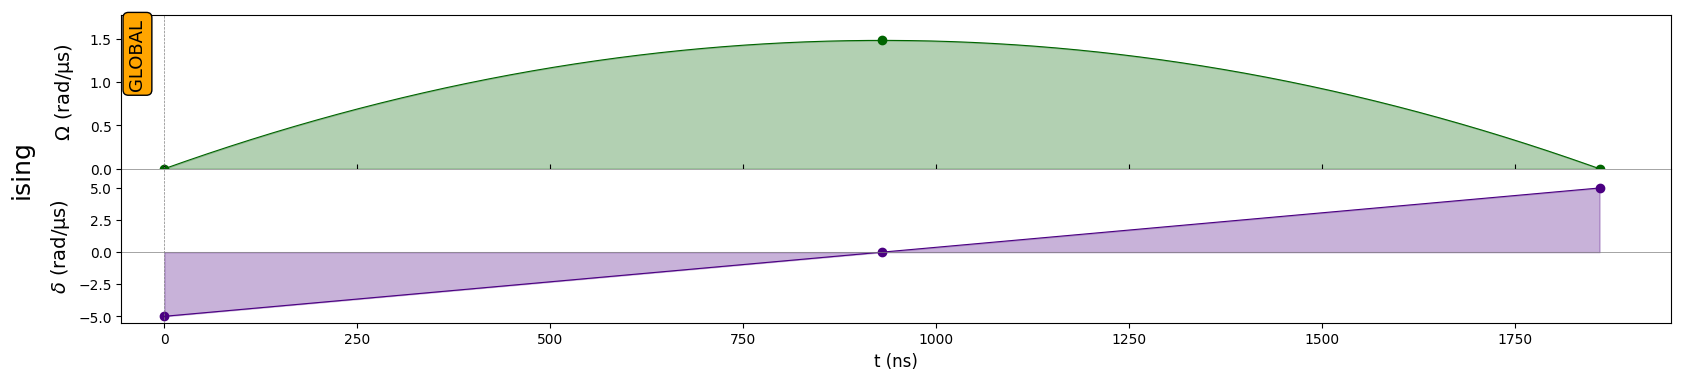

In [13]:
#Standard schedule

Omega = np.median(Q[Q > 0].flatten())
delta_0 = -5  # just has to be negative
delta_f = -delta_0  # just has to be positive

adiabatic_pulse = Pulse(
    InterpolatedWaveform(t, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(t, [delta_0, 0, delta_f]),
    0,
)
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse, "ising")
seq.draw()

# Computation of the reduction in annealing time

In [8]:
treshold = 0.8
min_index = np.argwhere(np.array(ar)>treshold).min()
min_index_baseline = np.argwhere(np.array(ar_baseline)>treshold).min()
delta_t = abs(times[min_index]-times[min_index_baseline])/times[min_index_baseline]

print(f"Time saved : {delta_t*100:.2f}%")

Time saved : 73.20%


# Computation of the average reduction on the stress of the grid

In [9]:
all_states = [''.join(map(str, bits)) for bits in product([0, 1], repeat=N*T)]

#obtain target outage for energy grid
P = params['P']
all_states_array = 2*np.array([list(map(int, list(x))) for x in all_states])
all_states_array -= np.asarray(1)
grid_violations = []
for i in all_states_array:
    i = i.reshape(-1,N)
    i = np.sum(i,axis=0)
    i -= np.asarray(P)
    i = abs(i)
    #mean violation over a single solution
    grid_violations.append(np.mean(i))

grid_violations = np.array(grid_violations)
mean_violation = np.mean(grid_violations)
print(f"Average reduction in stress of the grid: {mean_violation*100:.2f}%")

Average reduction in stress of the grid: 150.00%


# Noise analysys of 3x3 instance

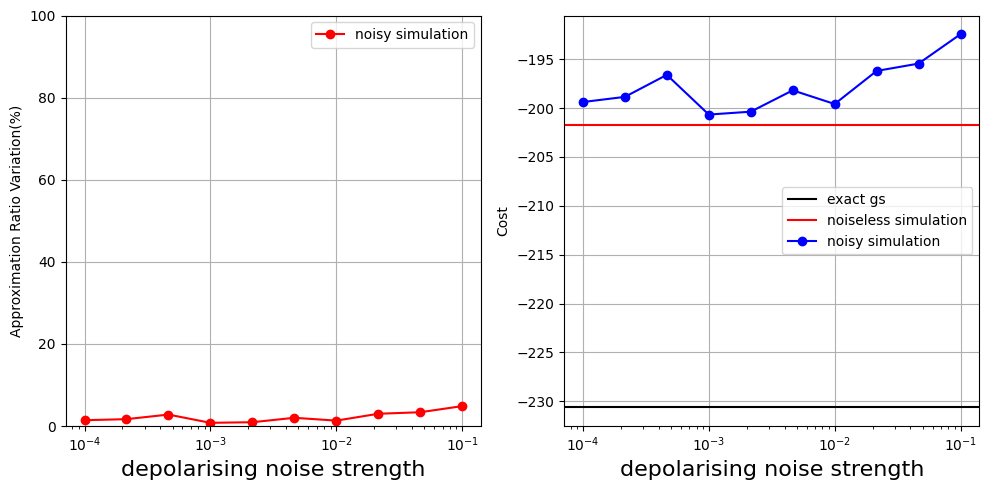

In [39]:
N = 3 
T_ev = 3

cost_noisy = np.load('results/cost_noisy_3_3.npy')
noise = np.load('results/noise_strength_3_3.npy')
res = pd.read_csv(f"results/output_{str(3)}_{str(3)}.csv")

cost_noisy.shape
# print(np.array(res['cost']))
# # plt.plot(cost_noisy)
# plt.plot(noise,cost_noisy[-1,:],'bo-')
# plt.plot(0.00001,np.array(res['cost'])[-1],'ro',label='statevector')
# plt.xscale('log')
# plt.ylabel('cost',fontsize=16)
# plt.xlabel('depolarising noise strength',fontsize=16)
# plt.axhline(y = float(res['exact_gs'][0]), color = 'k', linestyle = '-',label='exact ground state')
# plt.grid()
# plt.legend()

#computinh cost and ar variations
ar_noisy = [1-abs((gs - x)/gs) for x in cost_noisy[-1,:]]
ar_clean = ar[5]

delta_ar = [100*abs(x - ar_clean)/ar_clean for x in ar_noisy]
delta_cost = [100*abs(x - cost[5])/cost[5] for x in cost_noisy[-1,:]]

fig,axs = plt.subplots(ncols = 2, nrows = 1,figsize = (10,5))


axs[0].plot(noise,delta_ar,'ro-', label = "noisy simulation")
axs[0].set_xlabel('depolarising noise strength',fontsize=16)
axs[0].set_ylabel(r'Approximation Ratio Variation(%)')
axs[0].set_ylim(0,100)

axs[1].axhline(y = gs, color = 'k', linestyle = '-',label = 'exact gs')
axs[1].axhline(y = np.array(res['cost'])[-1], color = 'r', linestyle = '-',label = 'noiseless simulation')
axs[1].plot(noise,cost_noisy[-1,:],'bo-', label = "noisy simulation")
axs[1].set_xlabel('depolarising noise strength',fontsize=16)
axs[1].set_ylabel(r'Cost')
#axs[1].set_ylim(0,0.5)

for ax in axs:
    ax.set_xscale('log')
    ax.legend()
    ax.grid()
    #ax.set_ylim(0,1)
fig.tight_layout()
fig.savefig(f'results/ar_noisy_N{N}_T{T_ev}_{0}.png')

# 4x4 instance


In [42]:
N = 4 
T_ev = 4
cost_op = []
cost_bl = []
time = []
for ii in range(7):
    res = pd.read_csv(f"results/output_{str(N)}_{str(T_ev)}_{str(ii)}.csv")
    cost_bl.append(res['cost_baseline'])
    cost_op.append(res['cost'])
    time.append(float(res['time'])/1000)

gs = float(res['exact_gs'])

/tmp/ipykernel_29356/1815865740.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  time.append(float(res['time'])/1000)
/tmp/ipykernel_29356/1815865740.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  time.append(float(res['time'])/1000)
/tmp/ipykernel_29356/1815865740.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  time.append(float(res['time'])/1000)
/tmp/ipykernel_29356/1815865740.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  time.append(float(res['time'])/1000)
/tmp/ipykernel_29356/1815865740.py:10: FutureWarning: Calling float on a single element Series is deprecated and wil

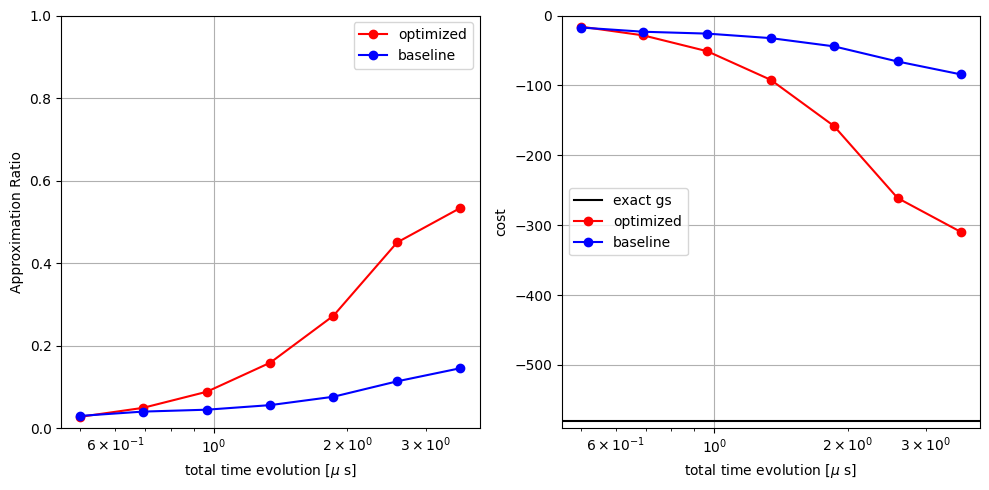

In [43]:
ar = [1-abs((gs - x)/gs) for x in cost_op]
ar_baseline = [1-abs((gs - x)/gs) for x in cost_bl]

fig,axs = plt.subplots(ncols = 2, nrows = 1,figsize = (10,5))

axs[0].plot(time,ar,'ro-',label='optimized')
axs[0].plot(time,ar_baseline,'bo-',label='baseline')
axs[0].set_xlabel(r'total time evolution [$\mu$ s]')
axs[0].set_ylabel(r'Approximation Ratio')
axs[0].set_ylim(0,1)

axs[1].axhline(y = gs, color = 'k', linestyle = '-',label = 'exact gs')
axs[1].plot(time,cost_op,'ro-',label='optimized')
axs[1].plot(time,cost_bl,'bo-',label='baseline')
axs[1].set_xlabel(r'total time evolution [$\mu$ s]')
axs[1].set_ylabel(r'cost')
axs[1].set_ylim(gs-10,0)

for ax in axs:
    ax.set_xscale('log')
    ax.legend()
    ax.grid()
    #ax.set_ylim(0,1)
fig.tight_layout()
fig.savefig(f'ar_size_N{str(N)}_T{str(T_ev)}.png')

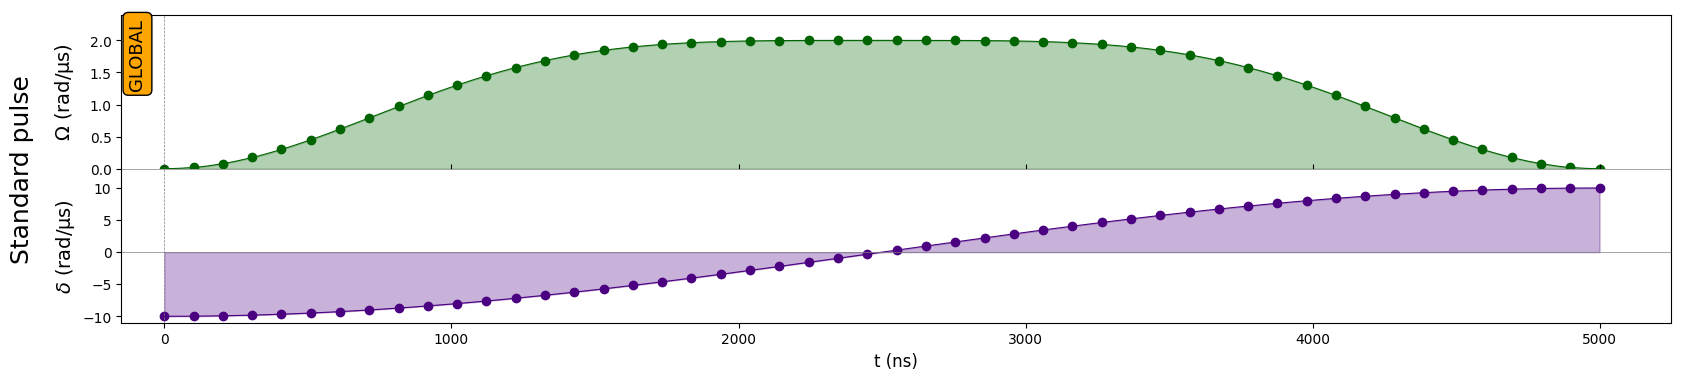

AttributeError: 'Sequence' object has no attribute 'savefig'

In [73]:
from main import load_parameters
N = 3 
T_ev = 3
omega = np.load(f'results/omega_schedules_{N}_{T_ev}.npy')
delta = np.load(f'results/delta_schedules_{N}_{T_ev}.npy')


adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, omega[-1,:]),
    InterpolatedWaveform(T, delta[-1,:]),
    0,
)

omega_max = 2
delta_max = 10 
time = np.linspace(0,T,50)
omega_pulse = omega_max*np.sin(np.pi/2*np.sin(np.pi*time/T))**2
delta_pulse = -delta_max*np.cos(np.pi*time/T) #smooth
adiabatic_pulse = Pulse(
        InterpolatedWaveform(T, omega_pulse),
        InterpolatedWaveform(T, delta_pulse),
        0,
    )

params, reg, Q = load_parameters(N, T_ev)
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("Standard pulse", "rydberg_global")
seq.add(adiabatic_pulse, "Standard pulse")
seq.draw()



